In [2]:
#!pip install configobj
import numpy as np
import lpdm
import scipy
from global_land_mask import globe
import netCDF4 as nc
from h5py import File
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import glob
import matplotlib.pyplot as plt

In [4]:
pwf = File('/Users/seancrowell/Google Drive/My Drive/CarbonFOX/simulations/halo/avg_kernels.h5','r')['pwf_no_norm'][:]
alts = File('/Users/seancrowell/Google Drive/My Drive/CarbonFOX/simulations/halo/avg_kernels.h5','r')['alt'][:]
emis_dir = '/Users/seancrowell/Google Drive/My Drive/CarbonFOX/simulations/nyc sims/emissions/'


# Create Column Footprints
### Compute unweighted and pressure weighted column average
### DON'T REPEAT THIS UNLESS FOOTPRINTS ARE UPDATED

In [66]:
out_dir = '../col_fps/column_fps/'
old_files = glob.glob(out_dir+'*col*')
for fi in old_files:
    os.remove(fi)

files = np.array(sorted(glob.glob('footprints/*foot.nc')))
lat_all = np.array([float(fi.split('_')[-3]) for fi in files])
lon_all = np.array([float(fi.split('_')[-4]) for fi in files])
lats = set(lat_all)
for lat in list(lats):
    lat_inds = np.where(lat_all == lat)[0]
    lons = set(lon_all[lat_inds])
    for lon in list(lons):
        inds = np.where((lat_all == lat)*(lon_all == lon))[0]
        inds = [i for i in inds]
        if len(inds) == 0: continue

        rec_files = files[inds]
        levs = np.array([int(fi.split('_')[-2]) for fi in rec_files])
        obs_t = rec_files[0].split('/')[-1].split('_')[0]
        col_fp = np.zeros((24,200,266))
        pwcol_fp = np.zeros((24,200,266))
        ptot = 0.
        for fi in rec_files:
            h = int(fi.split('_')[-2])
            lev = np.argwhere(alts == h)[0]
            nt = File(fi)['foot'][:].shape[0]
            col_fp[-nt:] += File(fi)['foot'][-nt:]
            pwcol_fp[-nt:] += File(fi)['foot'][-nt:]*pwf[lev]
            ptot += pwf[lev]
        col_fp /= len(rec_files)
        pwcol_fp /= ptot

        rec_fname_split = rec_files[0].split('/')[1].split('_')
        col_fname = ''
        low_fname = ''
        for i in range(3):
            col_fname += rec_fname_split[i]+'_'
            low_fname += rec_fname_split[i]+'_'
        col_fname += 'col_foot.nc'
        low_fname += '50_foot.nc'
        fout = Dataset(out_dir+col_fname,'w')
        fin = Dataset('footprints/'+low_fname,'r')
        for di,d in enumerate(['time','lat','lon']):
            fout.createDimension(d,pwcol_fp.shape[di])
        for v in ['time','lat','lon','foot']:
            fout.createVariable(v,fin[v].dtype,fin[v].dimensions)
            fout[v].units = fin[v].units
            
        fout['lat'][:] = fin['lat'][:]
        fout['lon'][:] = fin['lon'][:]
        fout['time'][:] = -(23-np.arange(24))*3600 + fin['time'][-1]
        fout['foot'][:] = pwcol_fp[:]
        fout.close()

NameError: name 'glob' is not defined

## Create Coarsened Files for Testing

In [ ]:
out_dir = 'footprints/coarse_col_footprints/'
old_files = glob.glob(out_dir+'*col*')
for fi in old_files:
    os.remove(fi)

files = np.array(sorted(glob.glob('footprints/*foot.nc')))
lat_all = np.array([float(fi.split('_')[-3]) for fi in files])
lon_all = np.array([float(fi.split('_')[-4]) for fi in files])
lats = set(lat_all)
for lat in list(lats):
    lat_inds = np.where(lat_all == lat)[0]
    lons = set(lon_all[lat_inds])
    for lon in list(lons):
        inds = np.where((lat_all == lat)*(lon_all == lon))[0]
        inds = [i for i in inds]
        if len(inds) == 0: continue

        rec_files = files[inds]
        levs = np.array([int(fi.split('_')[-2]) for fi in rec_files])
        obs_t = rec_files[0].split('/')[-1].split('_')[0]
        col_fp = np.zeros((24,100,133))
        pwcol_fp = np.zeros((24,100,133))
        ptot = 0.
        for fi in rec_files:
            h = int(fi.split('_')[-2])
            lev = np.argwhere(alts == h)[0]
            nt = File(fi)['foot'][:].shape[0]
            ft = File(fi)['foot'][-nt:]
            cft = np.zeros((nt,100,133))
            for ilat in range(100):
                cft[:,ilat,:] = ft[:,2*ilat:2*(ilat+1),0:-1:2].mean(1) + ft[:,2*ilat:2*(ilat+1),1::2].mean(1)
            col_fp[-nt:] += cft
            pwcol_fp[-nt:] += cft*pwf[lev]
            ptot += pwf[lev]
        col_fp /= len(rec_files)
        pwcol_fp /= ptot

        rec_fname_split = rec_files[0].split('/')[1].split('_')
        col_fname = ''
        low_fname = ''
        for i in range(3):
            col_fname += rec_fname_split[i]+'_'
            low_fname += rec_fname_split[i]+'_'
        col_fname += 'col_foot.nc'
        low_fname += '50_foot.nc'
        fout = Dataset(out_dir+col_fname,'w')
        fin = Dataset('footprints/'+low_fname,'r')
        for di,d in enumerate(['time','lat','lon']):
            fout.createDimension(d,pwcol_fp.shape[di])
        for v in ['time','lat','lon','foot']:
            fout.createVariable(v,fin[v].dtype,fin[v].dimensions)
            fout[v].units = fin[v].units
            
        fout['lat'][:] = 0.5*(fin['lat'][0:-1:2] + fin['lat'][1::2])
        fout['lon'][:] = 0.5*(fin['lon'][0:-1:2] + fin['lon'][1::2])
        fout['time'][:] = -(23-np.arange(24))*3600 + fin['time'][-1]
        fout['foot'][:] = pwcol_fp[:]
        fout.close()

### Write Obs Uncert File

In [3]:
files = np.array(sorted(glob.glob('mair/footprints/*foot.nc')))
unc = np.ones(len(files))*0.01**2
np.savetxt('r.txt',unc)

# Preparing Land Masks

In [2]:

lat = nc.Dataset('/Users/seancrowell/Google Drive/My Drive/CarbonFOX/simulations/mair/footprints/202309031436_-74.423_40.2674_1000_foot.nc')['lat'][:]
lon = nc.Dataset('/Users/seancrowell/Google Drive/My Drive/CarbonFOX/simulations/mair/footprints/202309031436_-74.423_40.2674_1000_foot.nc')['lon'][:]
lsm = np.zeros((len(lat),len(lon)))
for ilat in range(len(lat)):
    for ilon in range(len(lon)):
        lsm[ilat,ilon] = globe.is_land(lat[ilat],lon[ilon])
lsm_nyc = np.array(np.where(lsm > 0.5))
np.save('/Users/seancrowell/Google Drive/My Drive/CarbonFOX/simulations/mair//landmask_nyc.npy',lsm_nyc)

## Coarsened Land Mask for testing

In [3]:
lat = nc.Dataset('/Users/seancrowell/Google Drive/My Drive/CarbonFOX/simulations/mair/footprints/coarse_col_footprints/202309031436_-74.423_40.2674_col_foot.nc')['lat'][:]
lon = nc.Dataset('/Users/seancrowell/Google Drive/My Drive/CarbonFOX/simulations/mair/footprints/coarse_col_footprints/202309031436_-74.423_40.2674_col_foot.nc')['lon'][:]
lsm = np.zeros((len(lat),len(lon)))
for ilat in range(len(lat)):
    for ilon in range(len(lon)):
        lsm[ilat,ilon] = globe.is_land(lat[ilat],lon[ilon])
lsm_nyc = np.array(np.where(lsm > 0.5))
np.save('/Users/seancrowell/Google Drive/My Drive/CarbonFOX/simulations/mair//landmask_nyc_coarse.npy',lsm_nyc)

# Preparing Emissions

In [7]:
ro.r['load'](f"{emis_dir}ACES_CO2_2017_monthly_mean_NYCx.RData")
aces = np.array(ro.r['ACES_CO2_0.03x0.02'])#*12*(3600*24*31)/1e6
ro.r['load'](f"{emis_dir}EDGAR_v60_CO2_2018_monthly_NYCx.RData")
edgar = np.array(ro.r['EDGAR_CO2_0.03x0.02'])#*12*(3600*24*31)/1e6
ro.r['load'](f"{emis_dir}Vulcan_CO2_2015_monthly_mean_NYCx.RData")
vulcan = np.array(ro.r['Vulcan_CO2_0.03x0.02'])#*12*(3600*24*31)/1e6

lat = nc.Dataset('/Users/seancrowell/Google Drive/My Drive/CarbonFOX/simulations/mair/footprints/col_footprints/202309031436_-74.423_40.2674_col_foot.nc')['lat'][:]
lon = nc.Dataset('/Users/seancrowell/Google Drive/My Drive/CarbonFOX/simulations/mair/footprints/col_footprints/202309031436_-74.423_40.2674_col_foot.nc')['lon'][:]

f_out = File(emis_dir+'emis_2km_3km.h5','w')
f_out.create_dataset('aces',data=aces[:])
f_out.create_dataset('vulcan',data=vulcan[:])
f_out.create_dataset('edgar',data=edgar[:])
f_out.create_dataset('lat',data=lat[:])
f_out.create_dataset('lon',data=lon[:])
f_out.close()

In [9]:
lat.shape
lon.shape

(266,)

## Monthly mean emissions

In [10]:
aces = File(emis_dir+'emis_2km_3km.h5','r')['aces'][:]
vulcan = File(emis_dir+'emis_2km_3km.h5','r')['vulcan'][:]
edgar = File(emis_dir+'emis_2km_3km.h5','r')['edgar'][:]
lat = File(emis_dir+'emis_2km_3km.h5','r')['lat'][:]
lon = File(emis_dir+'emis_2km_3km.h5','r')['lon'][:]


aces_24hr_mean = aces.T.mean(1)#np.array([aces[:,:,:,i].T.mean(1) for i in range(12)])
edgar_24hr_mean = np.array([[[edgar[:,k,i,j].sum(0) for i in range(266)] for j in range(200)] for k in range(12)])
vulcan_24hr_mean = vulcan.T.mean(1)#np.array([vulcan[:,:,:,i].mean(2) for i in range(12)])

f_out = File(emis_dir+'monthly_emis_2km_3km.h5','w')
f_out.create_dataset('aces',data=aces_24hr_mean[:])
f_out.create_dataset('vulcan',data=vulcan_24hr_mean[:])
f_out.create_dataset('edgar',data=edgar_24hr_mean[:])
f_out.create_dataset('lat',data=lat[:])
f_out.create_dataset('lon',data=lon[:])
f_out.close()

/Users/seancrowell/miniconda3/envs/mpl/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


## Coarsened Fluxes for Testing

In [11]:
aces_coarse = np.zeros((aces_24hr_mean.shape[0],aces_24hr_mean.shape[1]//2,aces_24hr_mean.shape[2]//2))
vulcan_coarse = aces_coarse.copy()
edgar_coarse = aces_coarse.copy()
lat_c = 0.5*(lat[0:-1:2] + lat[1::2])
lon_c = 0.5*(lon[0:-1:2] + lon[1::2])

for ilat in range(100):
    aces_coarse[:,ilat,:] = aces_24hr_mean[:,2*ilat:2*(ilat+1),0:-1:2].mean(1) + aces_24hr_mean[:,2*ilat:2*(ilat+1),1::2].mean(1)
    vulcan_coarse[:,ilat,:] = vulcan_24hr_mean[:,2*ilat:2*(ilat+1),0:-1:2].mean(1) + vulcan_24hr_mean[:,2*ilat:2*(ilat+1),1::2].mean(1)
    edgar_coarse[:,ilat,:] = edgar_24hr_mean[:,2*ilat:2*(ilat+1),0:-1:2].mean(1) + edgar_24hr_mean[:,2*ilat:2*(ilat+1),1::2].mean(1)

f_out = File(emis_dir+'monthly_emis_4km_6km.h5','w')
f_out.create_dataset('aces',data=aces_coarse[:])
f_out.create_dataset('aces2x',data=aces_coarse[:]*2)
f_out.create_dataset('vulcan',data=vulcan_coarse[:])
f_out.create_dataset('edgar',data=edgar_coarse[:])
f_out.create_dataset('lat',data=lat_c[:])
f_out.create_dataset('lon',data=lon_c[:])
f_out.close()


#### Make Prior Files

In [8]:
#Vulcan
f_out = nc.Dataset('vulcan_4km_6km_prior_daily_mean.nc','w')
f_out.createDimension('time',16)
f_out.createDimension('lat',len(lat_c))
f_out.createDimension('lon',len(lon_c))
f_out.createVariable('lat','f4','lat')
f_out.createVariable('lon','f4','lon')
f_out.createVariable('sprior','f8',('time','lat','lon'))
f_out['lat'][:] = lat_c[:]
f_out['lon'][:] = lon_c[:]
f_out['sprior'][:] = np.array([vulcan_coarse[8] for i in range(0,48,3)])
f_out.close()

In [7]:
f_out.close()

In [21]:
#ACES
f_out = nc.Dataset('aces_4km_6km_prior_daily_mean.nc','w')
f_out.createDimension('time',16)
f_out.createDimension('lat',len(lat_c))
f_out.createDimension('lon',len(lon_c))
f_out.createVariable('lat','f4','lat')
f_out.createVariable('lon','f4','lon')
f_out.createVariable('sprior','f8',('time','lat','lon'))
f_out['lat'][:] = lat_c[:]
f_out['lon'][:] = lon_c[:]
f_out['sprior'][:] = np.array([aces_coarse[8] for i in range(0,48,3)])
f_out.close()

#ACES
f_out = nc.Dataset('aces2x_4km_6km_prior_daily_mean.nc','w')
f_out.createDimension('time',16)
f_out.createDimension('lat',len(lat_c))
f_out.createDimension('lon',len(lon_c))
f_out.createVariable('lat','f4','lat')
f_out.createVariable('lon','f4','lon')
f_out.createVariable('sprior','f8',('time','lat','lon'))
f_out['lat'][:] = lat_c[:]
f_out['lon'][:] = lon_c[:]
f_out['sprior'][:] = np.array([aces_coarse[8]*2 for i in range(0,48,3)])
f_out.close()

#ACES
f_out = nc.Dataset('aces13x_4km_6km_prior_daily_mean.nc','w')
f_out.createDimension('time',16)
f_out.createDimension('lat',len(lat_c))
f_out.createDimension('lon',len(lon_c))
f_out.createVariable('lat','f4','lat')
f_out.createVariable('lon','f4','lon')
f_out.createVariable('sprior','f8',('time','lat','lon'))
f_out['lat'][:] = lat_c[:]
f_out['lon'][:] = lon_c[:]
f_out['sprior'][:] = np.array([aces_coarse[8]*1.3 for i in range(0,48,3)])
f_out.close()

In [10]:
#EDGAR
f_out = nc.Dataset('edgar_4km_6km_prior_daily_mean.nc','w')
f_out.createDimension('time',16)
f_out.createDimension('lat',len(lat_c))
f_out.createDimension('lon',len(lon_c))
f_out.createVariable('lat','f4','lat')
f_out.createVariable('lon','f4','lon')
f_out.createVariable('sprior','f8',('time','lat','lon'))
f_out['lat'][:] = lat_c[:]
f_out['lon'][:] = lon_c[:]
f_out['sprior'][:] = np.array([edgar_coarse[8] for i in range(0,48,3)])
f_out.close()

## Make prior uncert variance "sigma"

In [19]:
f_out = nc.Dataset('sigma_aces2x_4km_6km_prior_daily_mean.nc','w')
f_out.createDimension('time',16)
f_out.createDimension('lat',len(lat_c))
f_out.createDimension('lon',len(lon_c))
f_out.createVariable('lat','f4','lat')
f_out.createVariable('lon','f4','lon')
f_out.createVariable('sigma','f8',('time','lat','lon'))
f_out['lat'][:] = lat_c[:]
f_out['lon'][:] = lon_c[:]
f_out['sigma'][:] = np.abs(np.array([np.array([aces_coarse[8] for i in range(0,48,3)])]))
f_out.close()

f_out = nc.Dataset('sigma_aces1.3x_4km_6km_prior_daily_mean.nc','w')
f_out.createDimension('time',16)
f_out.createDimension('lat',len(lat_c))
f_out.createDimension('lon',len(lon_c))
f_out.createVariable('lat','f4','lat')
f_out.createVariable('lon','f4','lon')
f_out.createVariable('sigma','f8',('time','lat','lon'))
f_out['lat'][:] = lat_c[:]
f_out['lon'][:] = lon_c[:]
f_out['sigma'][:] = np.abs(np.array([np.array([aces_coarse[8]*0.3 for i in range(0,48,3)])]))
f_out.close()

f_out = nc.Dataset('sigma_vulcan_4km_6km_prior_daily_mean.nc','w')
f_out.createDimension('time',16)
f_out.createDimension('lat',len(lat_c))
f_out.createDimension('lon',len(lon_c))
f_out.createVariable('lat','f4','lat')
f_out.createVariable('lon','f4','lon')
f_out.createVariable('sigma','f8',('time','lat','lon'))
f_out['lat'][:] = lat_c[:]
f_out['lon'][:] = lon_c[:]
f_out['sigma'][:] = np.abs(np.array([np.array([vulcan_coarse[8]-aces_coarse[8] for i in range(0,48,3)])]))
f_out.close()

# Prepare Obs and Background

### Coarsened Obs for Testing

In [22]:
with open('../coarse_col_receptors.asc') as f:
    files = f.read().splitlines()

ctl = lpdm.lpdm('config.ini')

bkg = 400.*np.ones(len(files))
emis = dict.fromkeys(['aces','aces2x','aces13x','vulcan','edgar'])
for ky in list(emis.keys()):
    emis[ky] = ctl.load_file(f'{ky}_4km_6km_prior_daily_mean.nc','sprior')

dxco2 = dict.fromkeys(emis.keys())
for ky in list(dxco2.keys()):
    dxco2[ky] = ctl.convolve(emis[ky])
#for i,fi in enumerate(files):
#    ft = nc.Dataset(fi)['foot'][:]
#   for ky in list(dxco2.keys()):
#        dxco2[ky][i] = (ft*emis[ky][8][None]).sum()

for ky in list(dxco2.keys()):
    np.savetxt(f'{ky}_obs.txt',dxco2[ky]+bkg,fmt='%6.3f')
    np.savetxt(f'{ky}_dxco2.txt',dxco2[ky],fmt='%6.3f')

In [17]:
uncert = 2.0
np.savetxt('r_2.0ppm.txt',uncert**2*np.ones(len(files)))

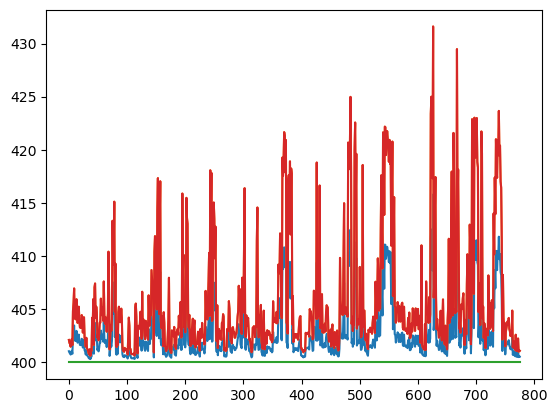

In [42]:
yp = np.loadtxt('aces_obs.txt')
yt = np.loadtxt('aces2x_obs.txt')
bkg = np.loadtxt('bkg.txt')
obs = np.loadtxt('obs.txt')
plt.plot(yp)
plt.plot(yt)
plt.plot(bkg)
plt.plot(obs)


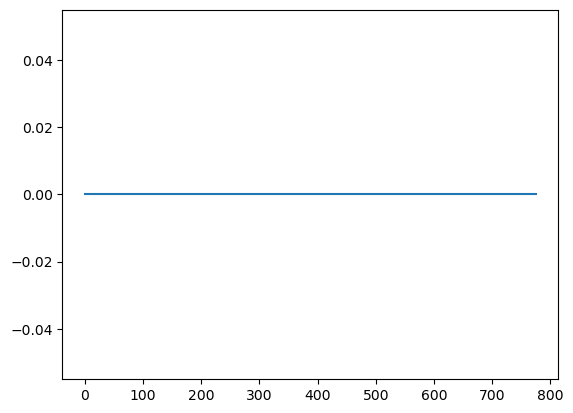

In [44]:
obs_bkg = np.loadtxt('obs-bg.txt')
yt_bkg = np.loadtxt('aces2x_dxco2.txt')
plt.plot(obs_bkg-yt_bkg)